In [341]:
import src.backtest_utils as sbtu
import pickle
import pandas as pd

In [342]:
_data_loader = sbtu.DataLoader.init_from_paths('other.json', 'base.json')
_strategy_path = _data_loader.file_path('strategy_lookup.pkl')
with open(_strategy_path, 'rb') as f:
    _strategy_lookup = pickle.load(f)

_bench_str = 'SPY'
_interval = '15m'
_price_data = pd.read_csv(_data_loader.history_path(_bench_str, _interval), index_col=0, header=[0,1]).iloc[1:].astype('float64')
_price_data.index = pd.to_datetime(_price_data.index, utc=True)
_bench = pd.read_csv(_data_loader.bench_path(_bench_str, _interval), index_col=0).astype('float64')
_bench.index = pd.to_datetime(_bench.index, utc=True)
_relative_rebased = sbtu.PriceGlob(_price_data).relative_rebased(_bench.close)
_strategy_overview = pd.read_csv(_data_loader.file_path('stat_overview_15m.csv'))

_price_data_by_symbol = sbtu.PriceGlob(_price_data).swap_level()

<AxesSubplot:>

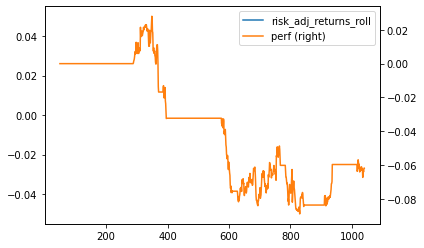

In [343]:
symbol = 'LH'
_strat_data = _strategy_lookup[symbol]
_stats = _strategy_lookup[symbol].stat_historical

_stats[['risk_adj_returns_roll', 'perf']].plot(use_index=False, secondary_y=['perf'])


<AxesSubplot:>

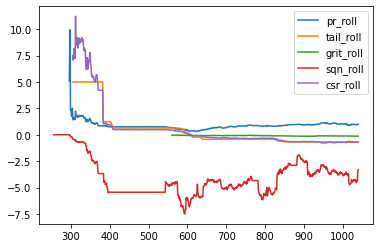

In [344]:
plot_copy = _stats[['pr_roll', 'tail_roll', 'grit_roll', 'sqn_roll', 'csr_roll']]
plot_copy.plot(use_index=False)

<AxesSubplot:title={'center':'LH'}>

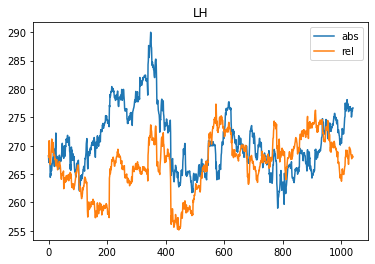

In [345]:
# base = 90
# for i in range(10):
#     quick_plot(base+i)
import src.utils.regime as sur
_symbol_data = _price_data_by_symbol.data[symbol]
_relative = sur.simple_relative(_symbol_data, _bench.close).close
_abs_rel_close = pd.DataFrame(
    data={
        'abs': _symbol_data.close,
        'rel': _relative
    }
)
_abs_rel_close.plot(title=symbol, use_index=False)

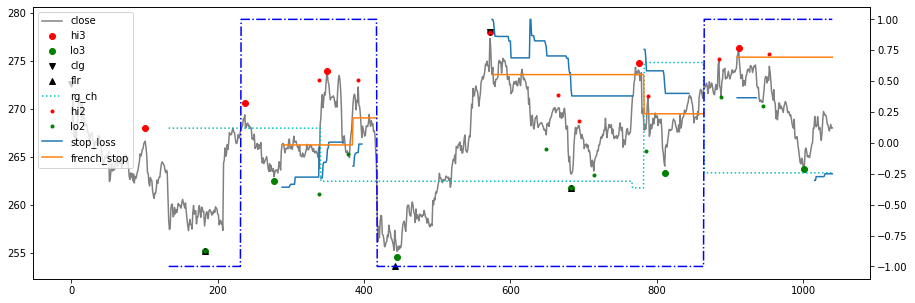

In [346]:
import src.scanner as scanner
epd = _strategy_lookup[symbol].enhanced_price_data.copy()
epd['french_stop'] = _strategy_lookup[symbol].french_stop.stop_price
_sl = _strategy_lookup[symbol].stop_loss_series
_sl = _sl.loc[~_sl.index.duplicated(keep='first')]
epd['stop_loss'] = _sl
# epd['base_close'] = _symbol_data.close
scanner.enhanced_price_data_plot(epd)

In [347]:
# _sd = _symbol_data.copy()
# _sd['french_stop'] = _strategy_lookup[symbol].french_stop.stop_price * (_bench.close/_bench.close.iloc[0])
# _sd['stop_loss'] = _strategy_lookup[symbol].stop_loss_series * (_bench.close/_bench.close.iloc[0])
# _sd[['close', 'french_stop', 'stop_loss']].plot(use_index=False, figsize=(15, 5))

In [348]:
# scanner.rolling_plot(
#     _symbol_data,
#     epd,
#     stop_loss_t=_strategy_lookup[symbol].stop_loss_series,
#     ticker=symbol
# )
import src.utils.pd_accessors as pda
import numpy as np
_pt = _strategy_lookup[symbol].peak_table.copy()

_pt['px'] = np.where(
    _pt.type == 1,
    epd.low.loc[_pt.start],
    epd.high.loc[_pt.start],
)
_pt = pda.PeakTable(_pt)
_pt = _pt.unpivot('15T', _symbol_data.index)
_pt = _pt.loc[~_pt.index.duplicated(keep='first')]
_shi_px = _pt.loc[(_pt.type == -1)]
_shi_1 = _shi_px.loc[(_shi_px.lvl == 1), 'px']
_shi_2 = _shi_px.loc[(_shi_px.lvl == 2), 'px']
_shi_3 = _shi_px.loc[(_shi_px.lvl == 3), 'px']

_slo_px = _pt.loc[(_pt.type == 1)]
_slo_1 = _slo_px.loc[(_slo_px.lvl == 1), 'px']
_slo_2 = _slo_px.loc[(_slo_px.lvl == 2), 'px']
_slo_3 = _slo_px.loc[(_slo_px.lvl == 3), 'px']



<AxesSubplot:>

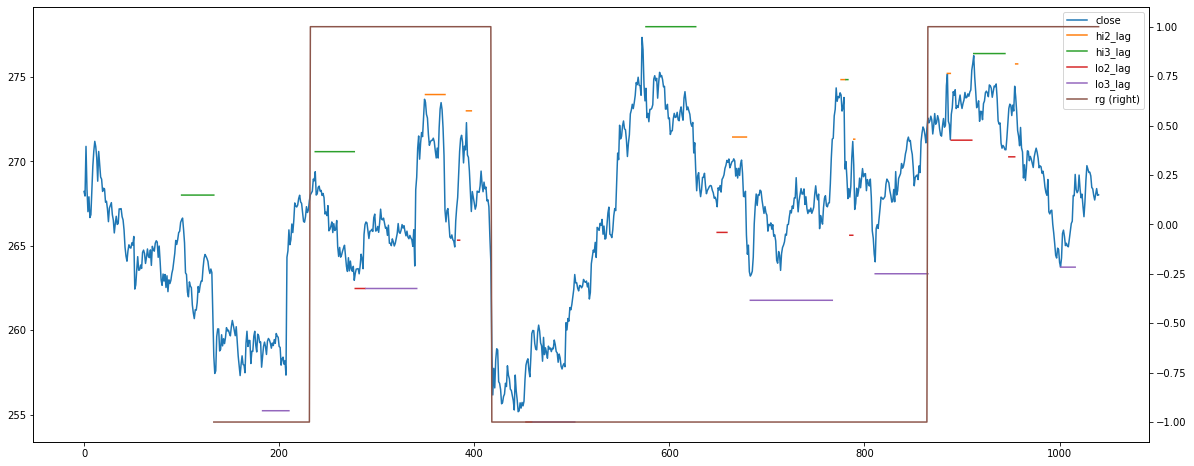

In [349]:
epd['hi1_lag'] = _shi_1
epd['hi2_lag'] = _shi_2
epd['hi3_lag'] = _shi_3
epd['lo1_lag'] = _slo_1
epd['lo2_lag'] = _slo_2
epd['lo3_lag'] = _slo_3



epd[
    ['close', 'hi2_lag', 'hi3_lag', 'lo2_lag', 'lo3_lag', 'rg']
].plot(use_index=False, figsize=(20, 8), secondary_y='rg')

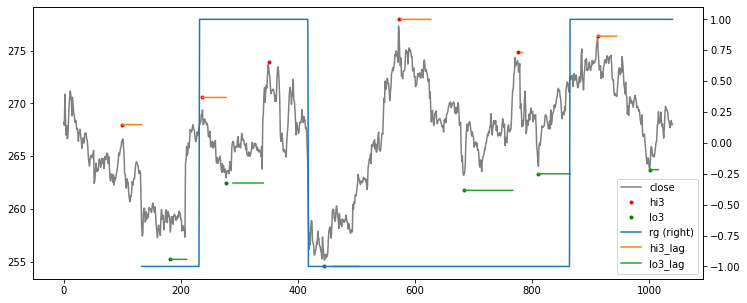

In [350]:
import src.utils.regime as regime
import matplotlib.pyplot as plt

_epd_plt = epd[['close', 'hi2', 'lo2', 'hi3', 'lo3', 'rg']]

def plot(lvl):
    epd[['close', f'hi{lvl}', f'lo{lvl}', 'rg', f'hi{lvl}_lag', f'lo{lvl}_lag']].plot(style=['grey', 'r.', 'g.'], use_index=False, figsize=[12, 5], secondary_y='rg')

plot(3)

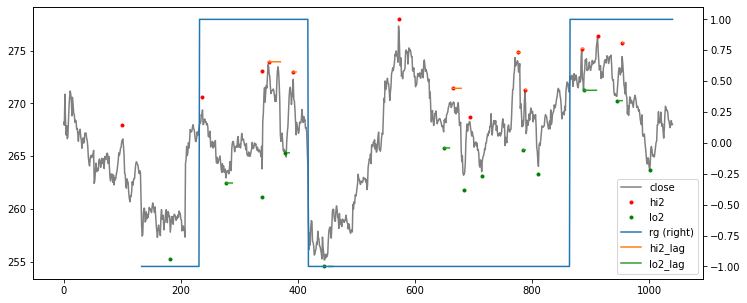

In [351]:
plot(2)

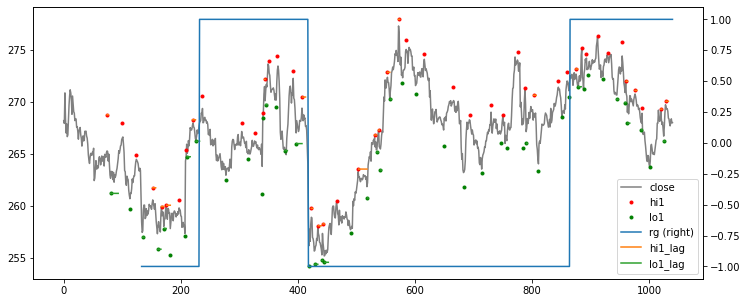

In [352]:
plot(1)

<AxesSubplot:ylabel='Frequency'>

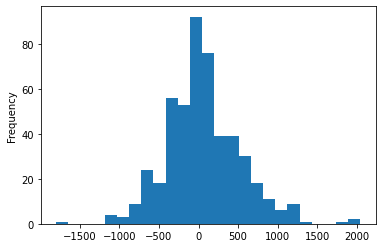

In [353]:
_strategy_overview.weight_total.plot.hist(bins=25)

<AxesSubplot:ylabel='Frequency'>

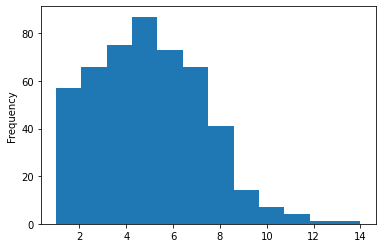

In [354]:
_strategy_overview.trades.plot.hist(bins=12)